In [84]:
!pip3 install -q numpy==1.22.4
!pip3 install -q pandas==2.1.0
!pip3 install -q matplotlib==3.7.2
!pip3 install -q seaborn==0.12.2
!pip3 install phik
!pip3 install sweetviz

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import sweetviz as sv

import os
import sys
import warnings


In [86]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

warnings.filterwarnings(action='ignore')

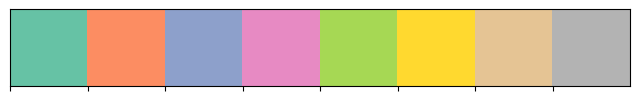

In [87]:
palette = sns.color_palette('Set2')
sns.palplot(palette)

# Загрузка датасета и первичный осмотр данных

In [88]:
path1 = '/datasets/train.csv'
path2 = '/datasets/test.csv'

def read_file(path):
    df = pd.DataFrame()
    if os.path.exists(path):
        df = pd.read_csv(path, sep=',')
    elif os.path.exists(path[1:]):
        df = pd.read_csv(path[1:], sep=',')
    else:
        print('No such file or directory') 
        raise FileNotFoundError('No such file or directory')
    return df

df_train = read_file(path1)
df_test = read_file(path2)

In [89]:
df_train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [90]:
df_test.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
5,0027_01,Earth,False,F/7/P,TRAPPIST-1e,31.0,False,0.0,1615.0,263.0,113.0,60.0,Karlen Ricks
6,0029_01,Europa,True,B/2/P,55 Cancri e,21.0,False,0.0,NaN,0.0,0.0,0.0,Aldah Ainserfle
7,0032_01,Europa,True,D/0/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,Acrabi Pringry
8,0032_02,Europa,True,D/0/S,55 Cancri e,23.0,False,0.0,0.0,0.0,0.0,0.0,Dhena Pringry
9,0033_01,Earth,False,F/7/S,55 Cancri e,24.0,False,0.0,639.0,0.0,0.0,0.0,Eliana Delazarson


In [91]:
display(df_train.describe(), df_test.describe())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [92]:
display(df_train.describe(include=['O']), df_test.describe(include=['O']))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,4277,4190,4184,4177,4185,4184,4183
unique,4277,3,2,3265,3,2,4176
top,0013_01,Earth,False,G/160/P,TRAPPIST-1e,False,Cints Erle
freq,1,2263,2640,8,2956,4110,2


---

# Анализ имеющихся проблем с данными

In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [95]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [96]:
df_test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [97]:
def pass_value_barh(dfg, set_name, color='#1f77b4'):
    try:
        ax = (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 12, color=color)
        )
        ax.set_title(f'Percentage of Missing Values in {set_name} Columns\n', fontsize=20, color='steelblue')
        ax.set_xlabel('Percentage Missing', fontsize = 16)
        ax.set_ylabel('Columns', fontsize = 16)
        ax.grid(axis='x', linestyle='--', alpha=0.5)
        ax.bar_label(ax.containers[0], label_type='edge', fmt='%.2f%%')
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

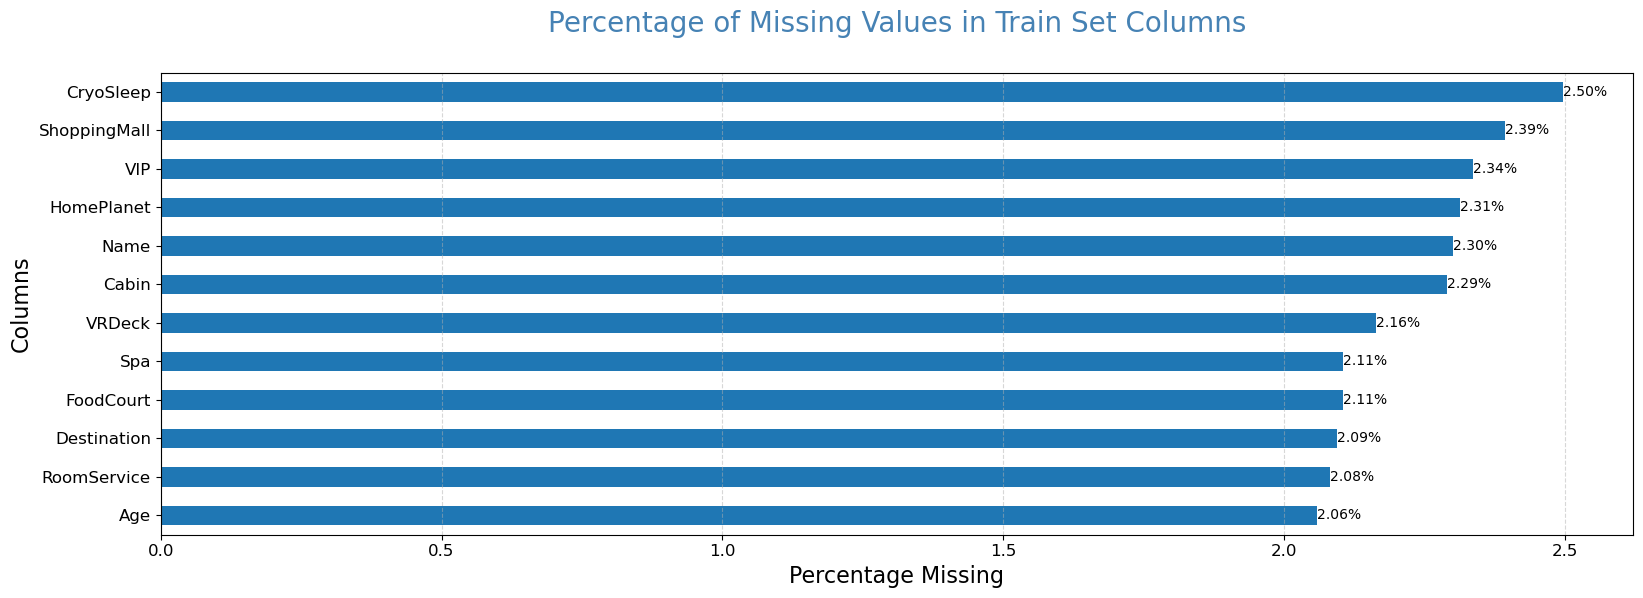

In [98]:
pass_value_barh(df_train, 'Train Set')

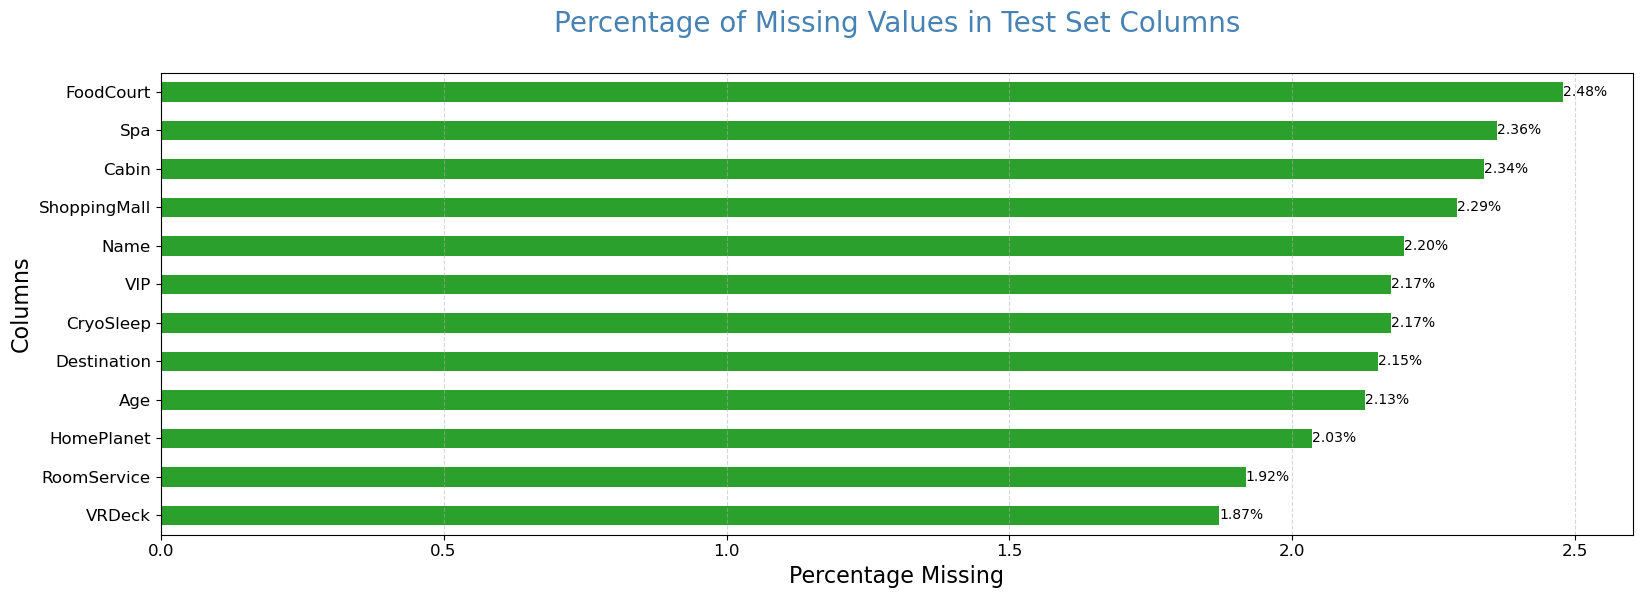

In [99]:
pass_value_barh(df_test, 'Test Set', color='#2ca02c')

In [100]:
print(df_train.duplicated().sum(), df_test.duplicated().sum())

0 0


---

# Предобработка данных и первичный анализ

In [101]:
def plot_size(column, labels, explode, palette):
    values = df_train[column].value_counts()
    
    lb = ''
    if labels == '':
        lb = values.index
    else:
        lb = labels
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 12), tight_layout=True)

    ax[0].bar(lb, values, color=palette)
    ax[0].grid(True, color='grey', axis='y', linestyle='-.', linewidth=0.5, alpha=0.6)
    ax[0].set_xlabel('Home Planet', fontsize=16)
    ax[0].set_ylabel('Number of transported clients', fontsize=14)
    ax[0].set_title(f'Total number of transported clients over {column}', fontsize=14)
    ax[0].bar_label(ax[0].containers[0], \
                 label_type='center', fmt='%.2f', fontsize=14, color='white')
    ax[0].tick_params(axis='x', labelsize=11)
    ax[0].tick_params(axis='y', labelsize=11)
    
    ax[1].pie(values, labels=lb, autopct='%1.2f%%', explode=explode, textprops={'fontsize':14}, startangle=100, colors=palette)
    ax[1].set_title(f'Percentage of {column} by the number of flights', fontsize=16)

    plt.show()
    
    return

In [ ]:
def plot_size_multiple(dfs, column, labels, explode, palette, width=6, height=5):
    df_number = len(dfs)
    fig, axs = plt.subplots(df_number, 2, figsize=(width, height * df_number), tight_layout=True)

    for i, df in enumerate(dfs):
        values = df_train[column].value_counts()
        
        lb = ''
        if labels == '':
            lb = values.index
        else:
            lb = labels

        axs[i][0].bar(lb, values, color=palette)
        axs[i][0].grid(True, color='grey', axis='y', linestyle='-.', linewidth=0.5, alpha=0.6)
        axs[i][0].set_xlabel('Home Planet', fontsize=16)
        axs[i][0].set_ylabel('Number of transported clients', fontsize=14)
        axs[i][0].set_title(f'Total number of transported clients over {column}', fontsize=14)
        axs[i][0].bar_label(ax[0].containers[0], \
                    label_type='center', fmt='%.2f', fontsize=14, color='white')
        axs[i][0].tick_params(axis='x', labelsize=11)
        axs[i][0].tick_params(axis='y', labelsize=11)
        
        axs[i][1].pie(values, labels=lb, autopct='%1.2f%%', explode=explode, textprops={'fontsize':14}, startangle=100, colors=palette)
        axs[i][1].set_title(f'Percentage of {column} by the number of flights', fontsize=16)

    plt.show()
    
    return

In [102]:
def plot_tab_multiple(dfs, column, horizontal=False, width=6, height=5):
    df_number = len(dfs)
    fig, axs = plt.subplots(df_number, 1, figsize=(width, height * df_number), tight_layout=True)
    
    for i, df in enumerate(dfs):
        tab = pd.crosstab(df[column], df['Transported'])
        display(tab)

        if horizontal:
            tab.div(tab.sum(axis=1), axis=0)[::-1].plot(kind="barh", stacked=True, color=[palette[1], palette[2]], ax=axs[i])
            axs[i].set_xlabel('Соотношение', fontsize=12)
            axs[i].set_ylabel(column, fontsize=12)
            axs[i].grid(True, color='grey', axis='x', linestyle='-.', linewidth=0.5, alpha=0.6)
            axs[i].set_xlim(0, 1)
            axs[i].set_xticks([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])        
            axs[i].legend(title='Transported', loc='upper left', labels=['False', 'True'], bbox_to_anchor=(1, 1))
            axs[i].axvline(x=0.5, color='green', linestyle='--', alpha=0.7)
        else:
            tab.div(tab.sum(axis=1), axis=0).plot(kind="bar", stacked=True, color=[palette[1], palette[2]], ax=axs[i])
            axs[i].set_xlabel(column)
            axs[i].set_ylabel('Соотношение')
            axs[i].grid(True, color='grey', axis='y', linestyle='-.', linewidth=0.5, alpha=0.6)
            axs[i].legend(title='Transported', loc='upper left', labels=['False', 'True'], bbox_to_anchor=(1, 1))

        plt.xticks(rotation=0)
        axs[i].bar_label(axs[i].containers[0], label_type='center', fmt='%.2f')
        axs[i].bar_label(axs[i].containers[1], label_type='center', fmt='%.2f')
        axs[i].tick_params(axis='x', labelsize=10)
        axs[i].tick_params(axis='y', labelsize=10)
        axs[i].set_title(f'Столбиковые графики соотношения числа пассажиров, \n выживших и не выживших, по аттрибуту {column}')
    
    plt.show()
    
    return

---

## Transported

In [103]:
df_train['Transported'].value_counts(dropna=False)

Transported
True     4378
False    4315
Name: count, dtype: int64

In [104]:
df_train['Transported'].dtype

dtype('bool')

,count
Transported,
True,4378
False,4315


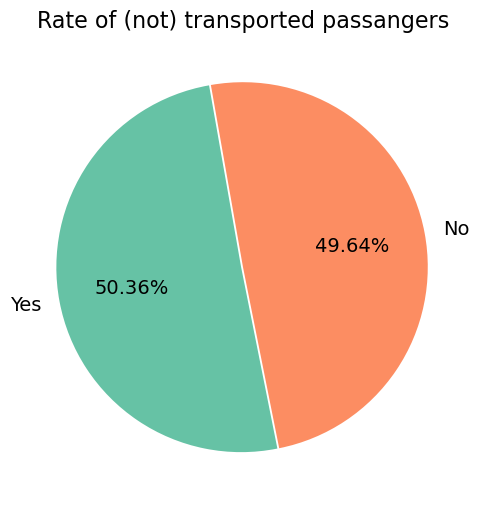

In [105]:
passanger_transported = df_train['Transported'].value_counts()

plt.figure(figsize=(8, 6))

plt.pie(passanger_transported, labels=['Yes', 'No'],
                                    autopct='%1.2f%%', explode=(0.01, 0), textprops={'fontsize':14},
                                    startangle=100, colors=sns.color_palette('Set2'))
plt.title('Rate of (not) transported passangers', fontsize=16)

display(passanger_transported.to_frame())
plt.show()

Видно, что данные разделены практически идеально поровну на две категории. Лишний раз стратифицировать данные, скорее всего, не придется при составлении train, val и test датасетов (хотя test сет уже есть). Да и в общем с классами равного размера проще работать.

---

## HomePlanet

In [106]:
df_train['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

In [107]:
# как работает crosstab
# (df_train.groupby('HomePlanet')['Transported']
#  .value_counts()
#  .sort_index(level=[0, 1])
#  .to_frame()
#  .rename(columns={'Transported': 'count'})
# )

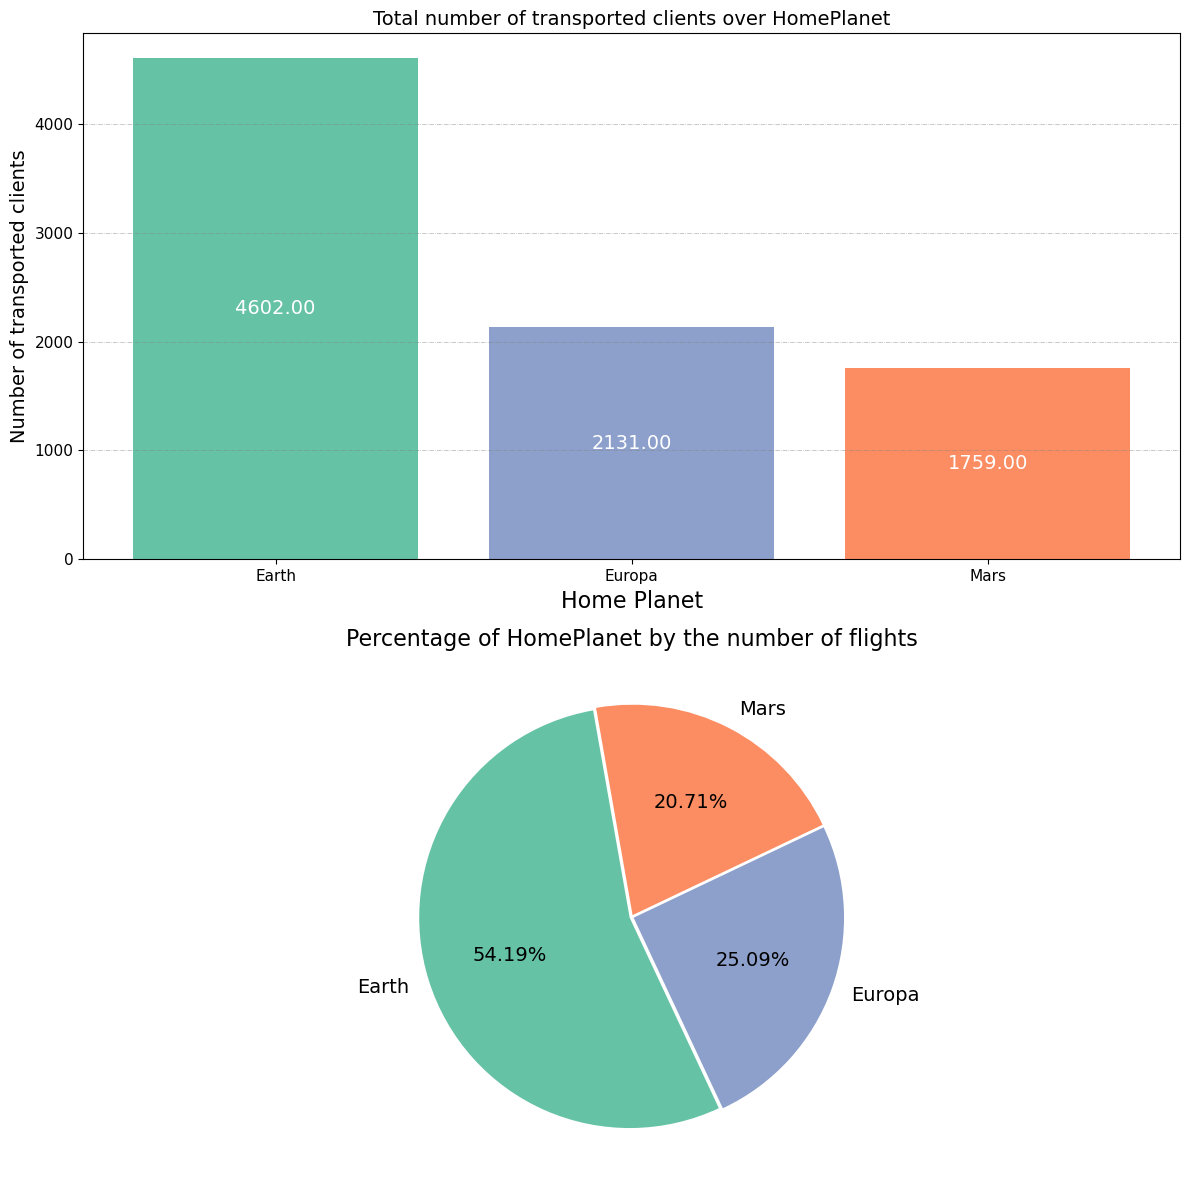

In [108]:
plot_size('HomePlanet', '', (0.01, 0.01, 0.01), [palette[0], palette[2], palette[1]])

In [109]:
tab = pd.crosstab(df_train['HomePlanet'], df_train['Transported'])
tab

Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


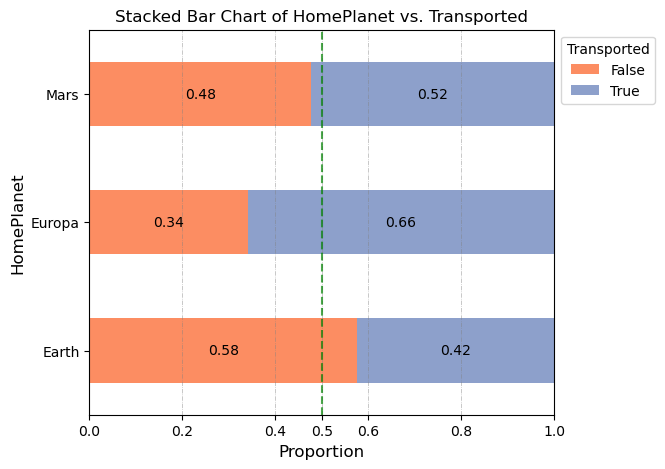

In [110]:
plot_tab('HomePlanet', True)

In [111]:
df_survived_homeplanet = (df_train.groupby('HomePlanet')['Transported']
 .mean()
 .to_frame()
 .rename(columns={'Transported': 'transported_rate'})
 .sort_values(by=['transported_rate'])
)
df_survived_homeplanet

,transported_rate
HomePlanet,
Earth,0.423946
Mars,0.523024
Europa,0.658846


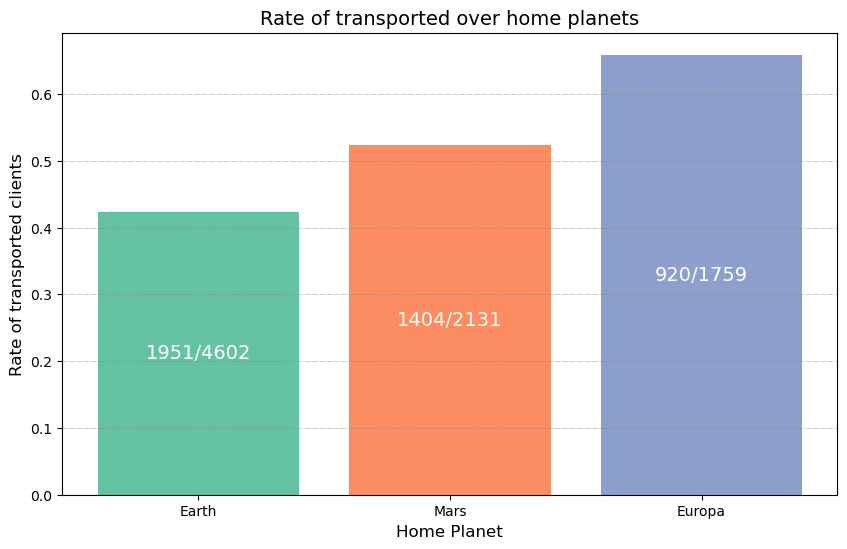

In [112]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(df_survived_homeplanet.index, df_survived_homeplanet.transported_rate, color=sns.color_palette('Set2'))
ax.grid(True, color='grey', axis='y', linestyle='-.', linewidth=0.5, alpha=0.6)
ax.set_xlabel('Home Planet', fontsize=12)
ax.set_ylabel('Rate of transported clients', fontsize=12)
ax.set_title('Rate of transported over home planets', fontsize=14)
ax.bar_label(bars, labels=[f'{y}/{x+y}' for x, y in tab[:].values], \
             label_type='center', fmt='%.2f', fontsize=14, color='white')

plt.show()

In [113]:
df_train[df_train['HomePlanet'].isna()]['Transported'].mean()

0.5124378109452736

In [114]:
df_train.loc[df_train['HomePlanet'].isna(), 'HomePlanet'] = 'Mars'
df_test.loc[df_train['HomePlanet'].isna(), 'HomePlanet'] = 'Mars'

In [32]:
df_train['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     4602
Europa    2131
Mars      1960
Name: count, dtype: int64

По графикам выше можно сделать несколько наблюдений:
* кол-во перелетов с Европы и с Марса довольно близко - $2131$ и $1759$ соответственно;
* больше всего путеществий наичанется с Земли - $4602$ перелета;
* чаще всего пассажиры успешно добирались до цели, стартуя с Европы - доля успехов около $2/3$;
* с Марса добираются до пунктов назначения примерно $50$% пассажиров (или скорее, что половина путешествий заканчивается успехом);
* чуть больше $40$% перелетов с Земли завершаются успешо.

Для всех имеющихся строк с пропуском в графе "HomePlanet" была посчитана средняя доля успешных перелетов, после чего все пропуски были добавлены к той их трех известных категорий, чей показатель среднего процента успешных перелетов был схожим. В данном случае это оказалась категория "Mars".

---

## CryoSleep

In [33]:
df_train['CryoSleep'].value_counts(dropna=False)

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

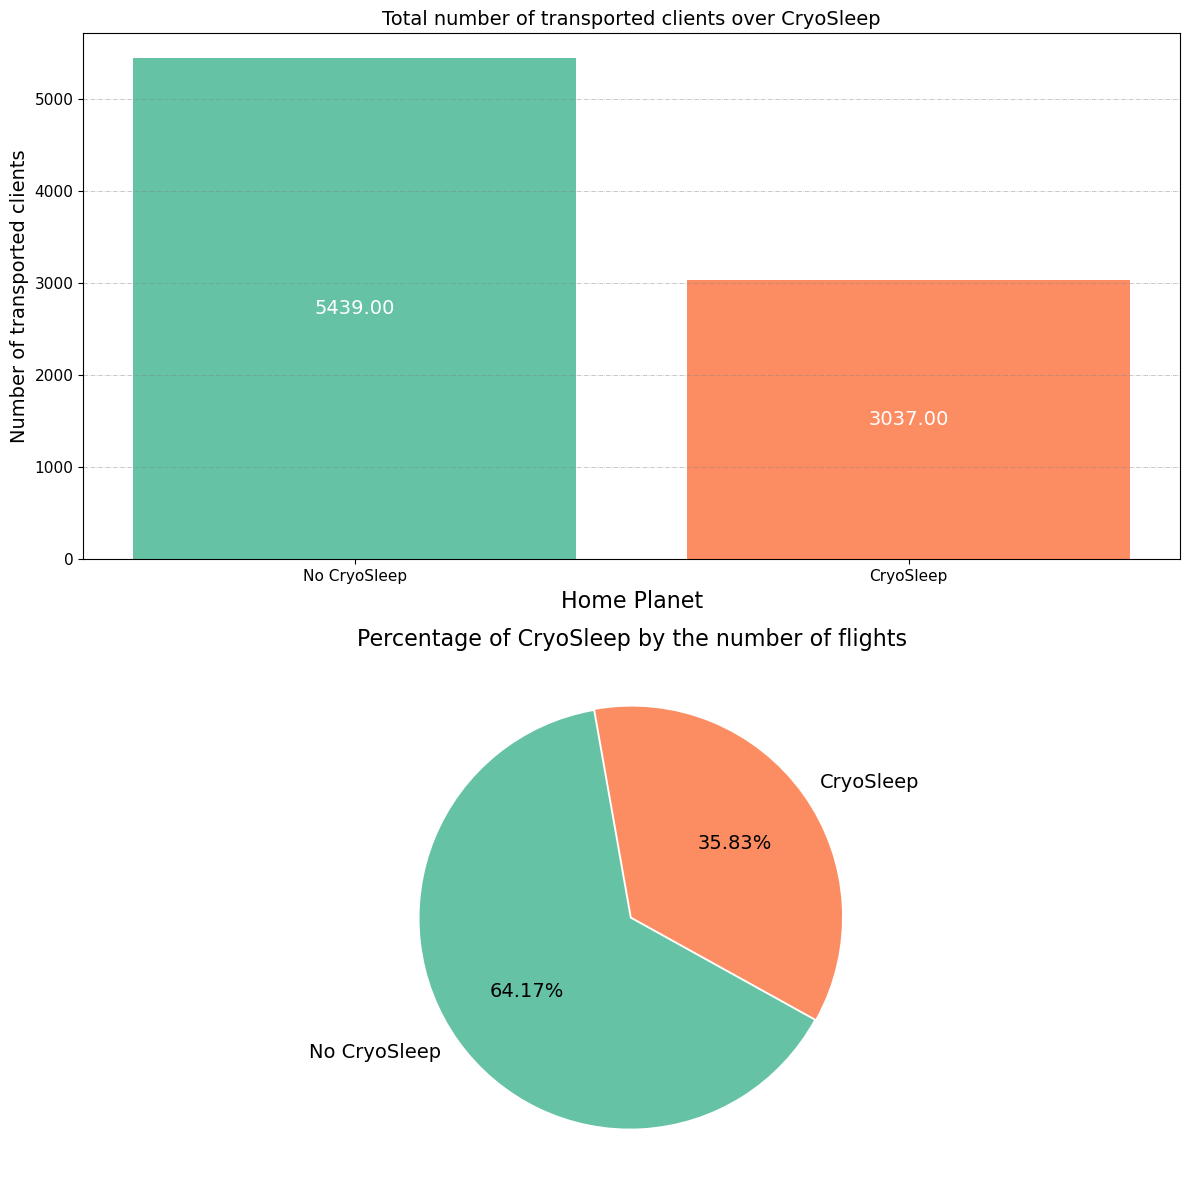

In [34]:
plot_size('CryoSleep', ['No CryoSleep', 'CryoSleep'], (0.01, 0), palette)

In [35]:
# df_cryo_transp = (df_train.groupby('CryoSleep')['Transported']
#  .value_counts()
#  .sort_index(level=[0, 1])
#  .unstack(level=1)
# )
# df_cryo_transp

tab = pd.crosstab(df_train['CryoSleep'], df_train['Transported'])
tab

Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


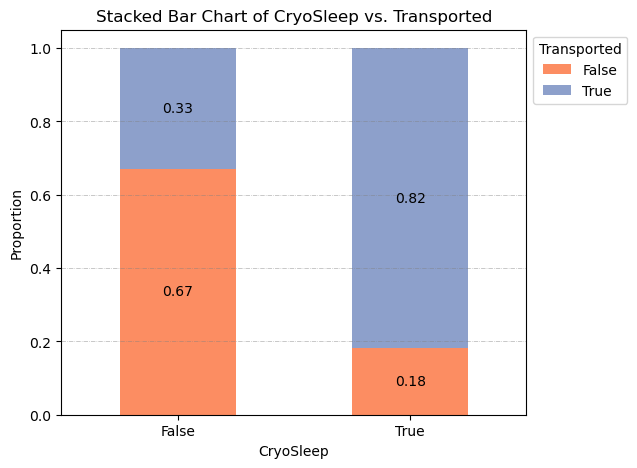

In [36]:
plot_tab('CryoSleep')

In [37]:
condition = df_train['CryoSleep'].isna()
selected_rows = df_train.loc[condition]

df_train.loc[condition, 'CryoSleep'] = \
    [True if tr else False for tr in selected_rows['Transported']]

In [38]:
df_train['CryoSleep'].value_counts(dropna=False)

CryoSleep
False    5550
True     3143
Name: count, dtype: int64

In [39]:
df_train['CryoSleep'] = df_train['CryoSleep'].astype(bool)
df_train['CryoSleep'].dtype

dtype('bool')

Судя по графикам выше, можно предположить, что данный параметр является довольно важным для дальнейшей классификации полетов и определения таргета. Явно имеется некая закономерность, что перелеты, совершаемые в состоянии криосна, заканчиваются успехами намного чаще, чем перелеты не в криосне.

---

## Cabin

In [40]:
df_train['Cabin'].isna().sum()

199

In [41]:
df_train['Cabin'] = df_train['Cabin'].apply(lambda x: x[-1] if pd.notna(x) else x)
df_train['Cabin'].head()

0    P
1    S
2    S
3    S
4    S
Name: Cabin, dtype: object

In [42]:
df_train['Cabin'].value_counts()

Cabin
S    4288
P    4206
Name: count, dtype: int64

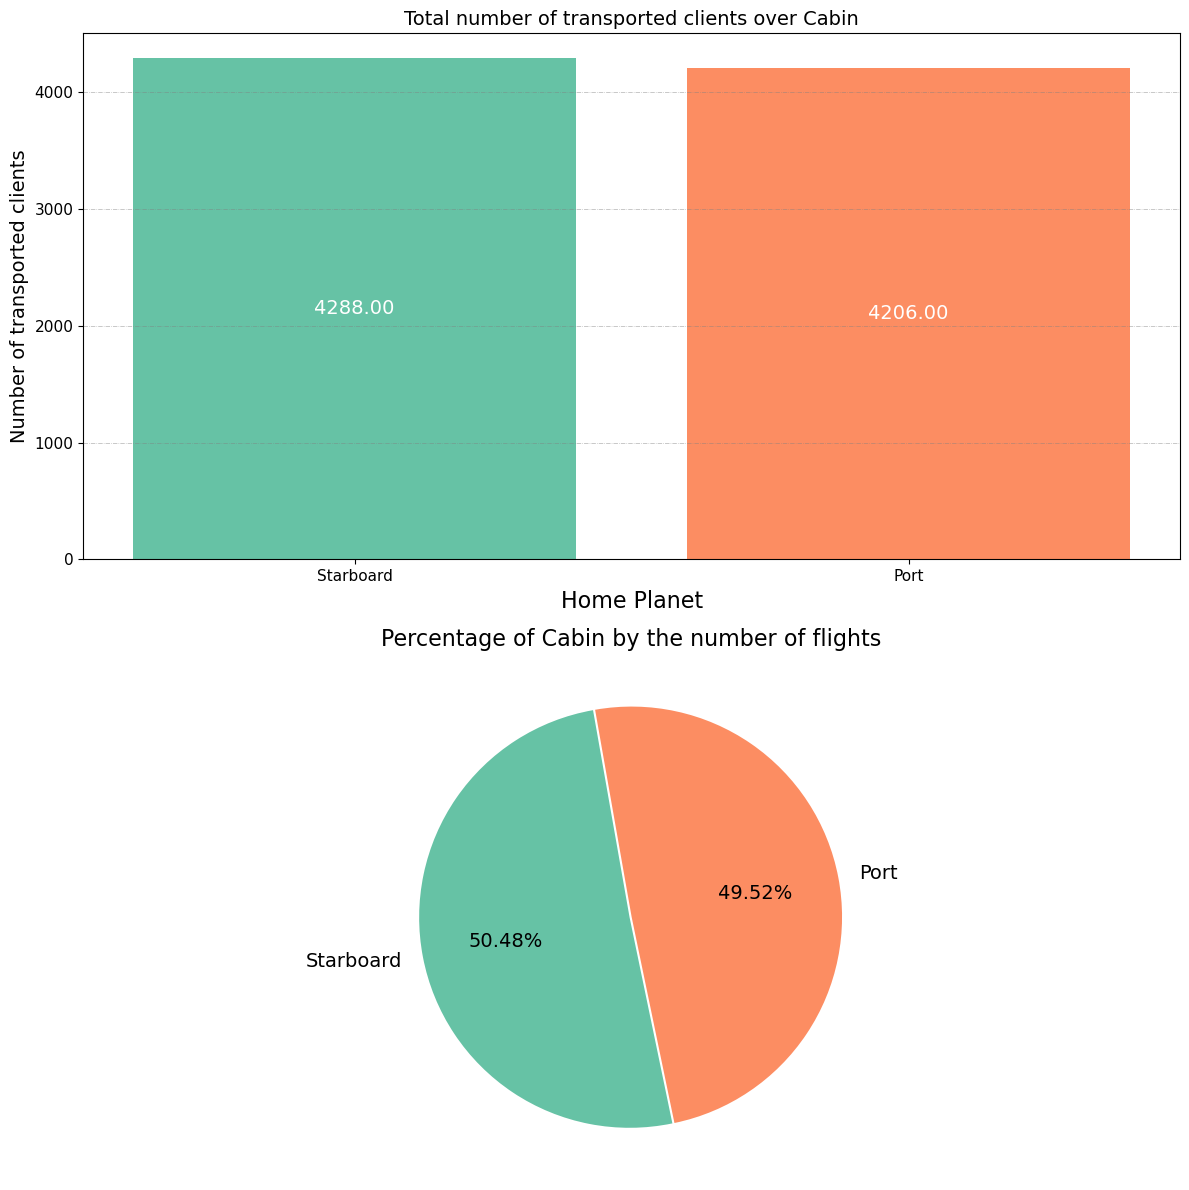

In [43]:
plot_size('Cabin', ['Starboard', 'Port'], (0.01, 0), palette)

Transported,False,True
Cabin,,
P,2308,1898
S,1908,2380


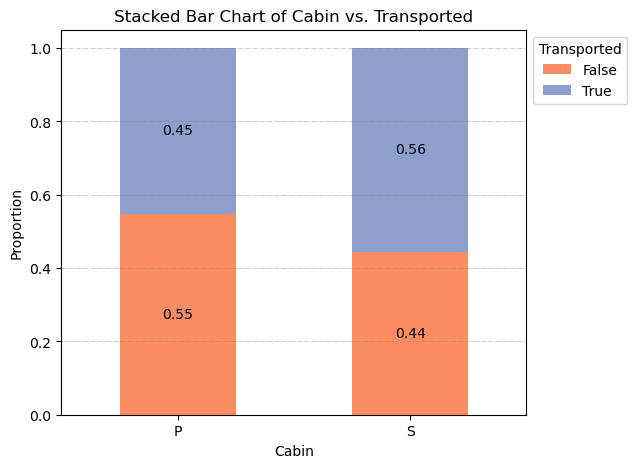

In [44]:
plot_tab('Cabin')

In [45]:
mask = df_train['Cabin'].isna()
nan_rows = df_train[mask]
split_point = len(nan_rows) // 2
nan_rows.loc[:, 'Cabin'] = ['P'] * split_point + ['S'] * (len(nan_rows) - split_point)

# df_train.update(nan_rows) # Почему-то когда я использую этот метод, теряются преобразования типов, сделанные ранее
df_train.loc[mask, 'Cabin'] = nan_rows
df_train['Cabin'].isna().sum()

0

Основная информация, несущая смысловую нагрузку данного параметра, потенциально полезная для будущей модели - это последняя буква в deck/num/side-коде кабины пассажира. Она говорит, с какой стороны расположена кабина (или место) пассажира. Решено оставить только эту букву, а всё до нее удалить.

Т.к. в датасете пассажиры равномерно распределены по двум возможным категориям (S и P), было решено разделить все пропуски поровну между этими двумя категориями.

---

## Destination

In [46]:
df_train['Destination'].value_counts(dropna=False).to_frame()

,count
Destination,
TRAPPIST-1e,5915
55 Cancri e,1800
PSO J318.5-22,796
NaN,182


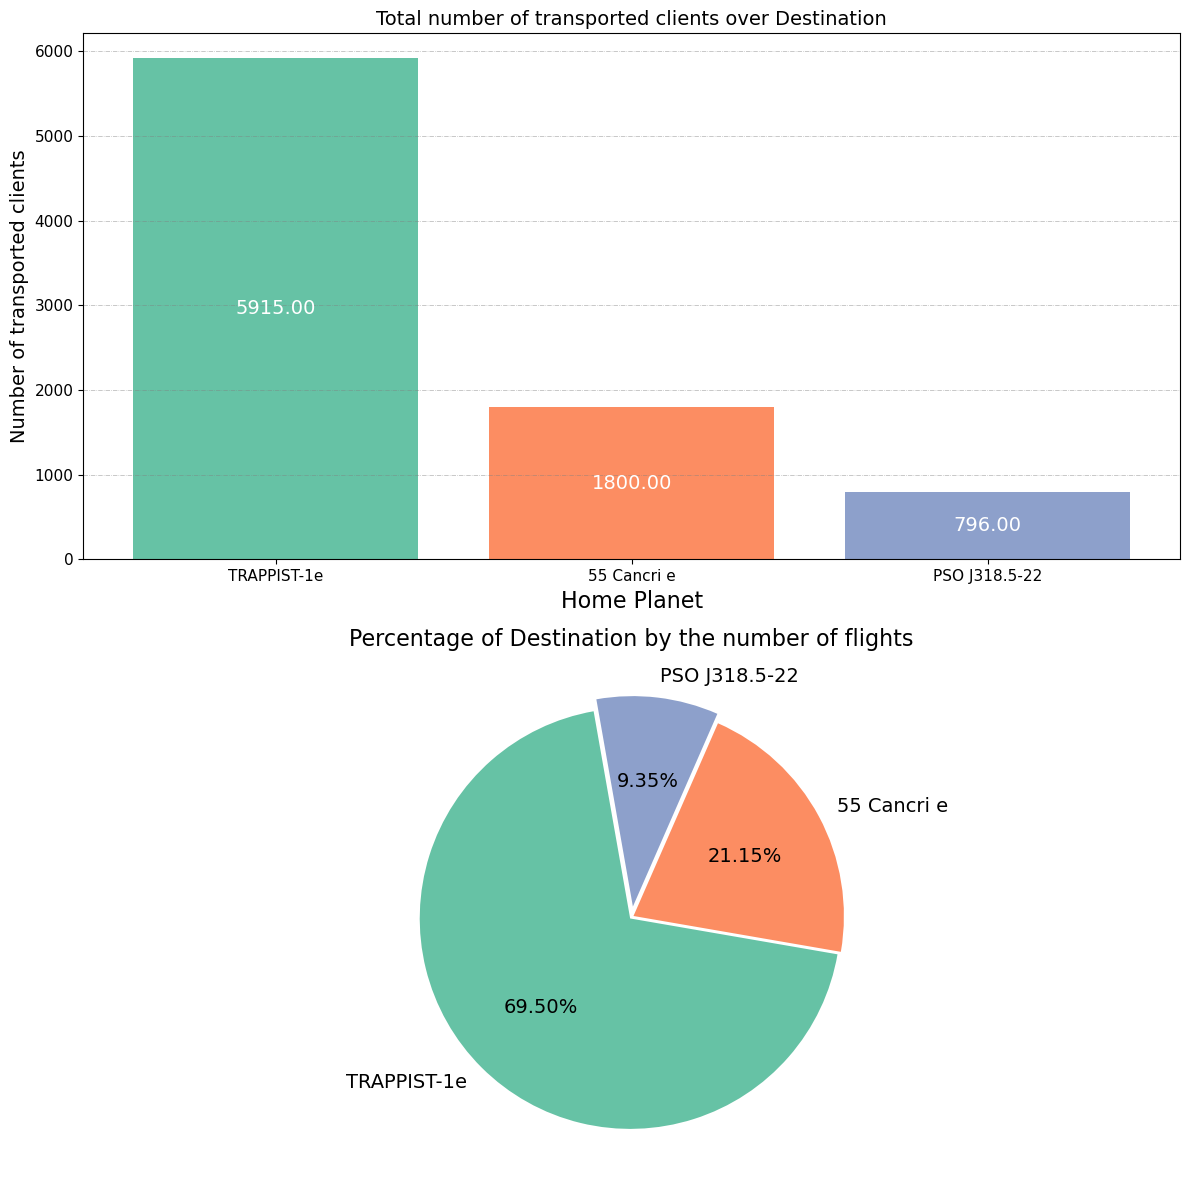

In [47]:
plot_size('Destination', '', (0.01, 0.01, 0.05), palette)

In [48]:
df_train[df_train['Destination'].isna()]['Transported'].mean()

0.5054945054945055

Transported,False,True
Destination,,
55 Cancri e,702,1098
PSO J318.5-22,395,401
TRAPPIST-1e,3128,2787


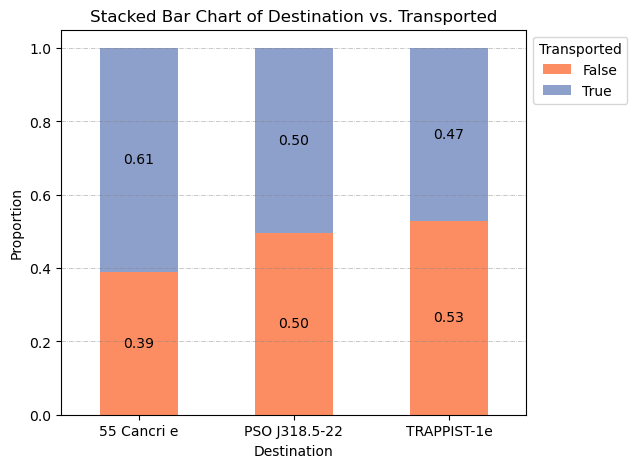

In [49]:
plot_tab('Destination')

In [50]:
df_survived_destination = (df_train.groupby('Destination')['Transported']
 .mean()
 .to_frame()
 .rename(columns={'Transported': 'transported_rate'})
 .sort_values(by=['transported_rate'])
)
df_survived_destination

,transported_rate
Destination,
TRAPPIST-1e,0.471175
PSO J318.5-22,0.503769
55 Cancri e,0.610000


Хоть средние показатели больше похожи на группу "PSO J318.5-22", но размеры группы не имеют порядковой разницы с количеством строк с пропуском. Поэтому присвоим всем пропускам значение самой крупной группы.

In [51]:
df_train.loc[df_train['Destination'].isna(), 'Destination'] = 'TRAPPIST-1e'
df_train['Destination'].isna().sum()

0

Здесь рассуждения и наблюдения схожи с теми, что были проведены с параметром HomePlanet.

---

## Age

In [52]:
df_train.Age.isna().sum()

179

In [53]:
df_train.Age.describe().to_frame()

,Age
count,8514.000000
mean,28.827930
std,14.489021
min,0.000000
25%,19.000000
50%,27.000000
75%,38.000000
max,79.000000


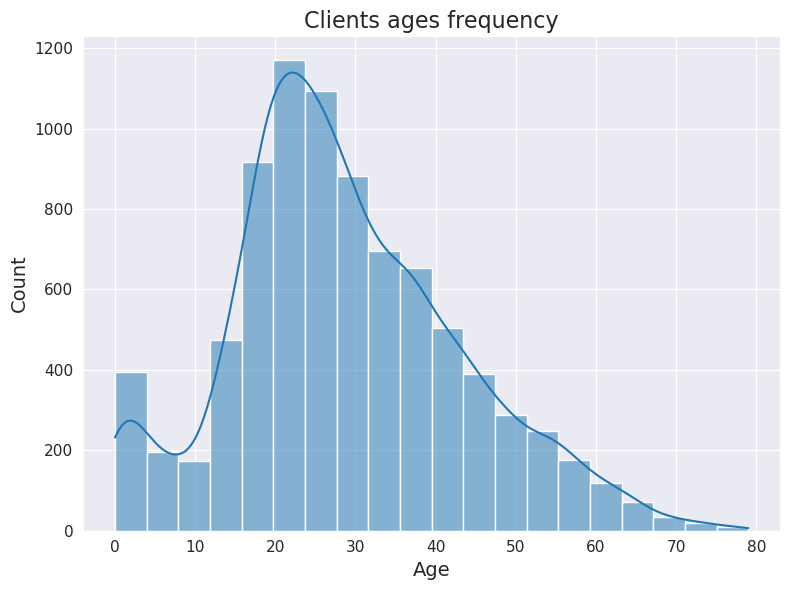

In [54]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(figsize=(8, 6), tight_layout=True)
    
    sns.histplot(data=df_train, x=df_train.Age, bins=20, kde=True, ax=axs)
    axs.set_title('Clients ages frequency', fontsize=16)
    axs.set_xlabel('Age', fontsize='14')
    axs.set_ylabel('Count', fontsize='14')
    axs.tick_params(axis='x', labelsize=11)
    axs.tick_params(axis='y', labelsize=11)

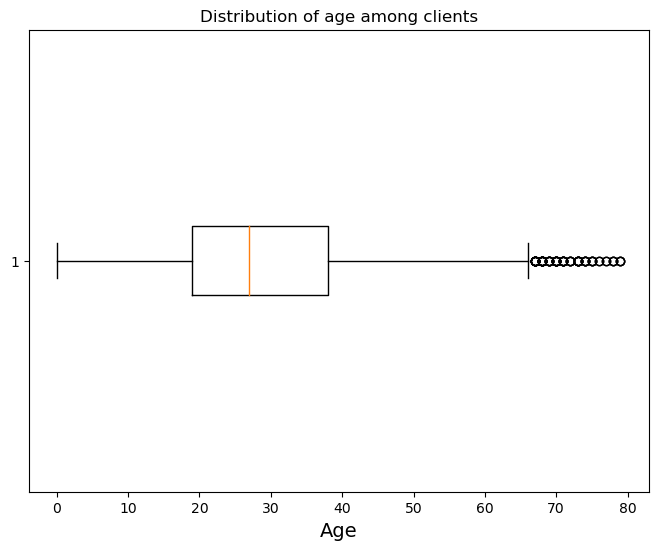

In [55]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_train.Age.dropna(), vert=False)
plt.title('Distribution of age among clients')
plt.xlabel('Age', fontsize=14)
plt.show()

In [56]:
df_train.loc[df_train.Age.isna(), 'Age'] = df_train.Age.mean()
df_train.Age.isna().sum()

0

Средний возраст пассажиров - около 27-30 лет, при этом более молодых клиентов (до 30) больше, чем более возростных (старше 30), что видно на гистограмме выше. Имеется два пика - в районе 20-25 лет и, что интересно, в самом начале графика распределения - в районе 0-4 лет. Т.е. имеется значительное число пассажиров-детей. редкостью являются пассажиры старше 66 лет.

Заполняем пропуски в возрасте пассажиров средним значением, т.к. это проще всего, а количество пропусков мало.

---

## VIP

In [57]:
df_train['VIP'].value_counts(dropna=False)

VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64

In [58]:
df_train['VIP'].isna().sum()

203

Transported,False,True
VIP,,
False,4093,4198
True,123,76


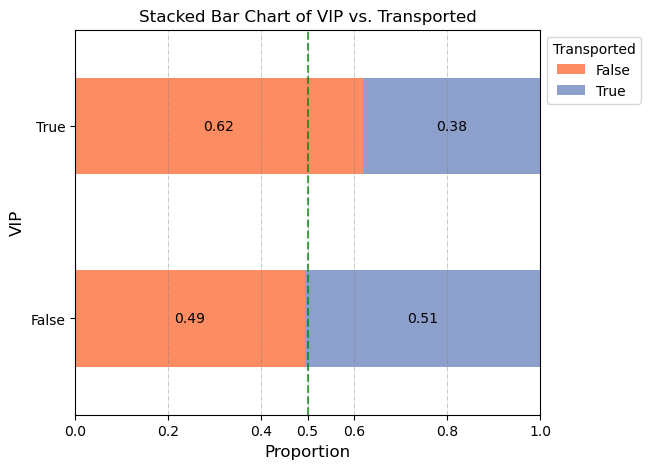

In [59]:
plot_tab('VIP', True)

In [60]:
df_train['VIP'].fillna(value=False, inplace=True)

Во-первых, VIP-клиентов крайне мало - всего 199 человек на более чем 8000. Во-вторых, замечается некоторая закономерность, что VIP-клиенты на 10% менее вероятно успешно заканчивают перелет. Однако стоит учитывать малые размеры выборки данной категории клиентов, поэтому проверка наличия данной закономерности требует отдельных исследований и стат. экспериментов.

Пропуски было решено заполнить значением False, т.е. отсутствием VIP-статуса у пассажира. Данная категория пассажирова намного крупнее и будет менее подвержена стат. изменениям при добавлении новых значений, в отличае от группы VIP-клиентов. Кроме того, данный подход интуитивно логичнее.

---

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [61]:
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [62]:
df_train[columns].isna().sum().to_frame().rename(columns={0: 'nans'})

,nans
RoomService,181
FoodCourt,183
ShoppingMall,208
Spa,183
VRDeck,188


In [63]:
df_train[columns].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [64]:
df_train[df_train[columns] > 0][columns].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,2935.000000,3054.000000,2898.000000,3186.000000,3010.000000
mean,651.632368,1276.436477,508.658385,831.070621,861.392027
std,1005.556487,2488.548489,948.906017,1737.733738,1797.300831
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,37.000000,39.000000,22.000000,27.000000,28.000000
50%,320.000000,396.500000,195.000000,226.500000,260.000000
75%,848.000000,1255.750000,693.000000,769.000000,806.500000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


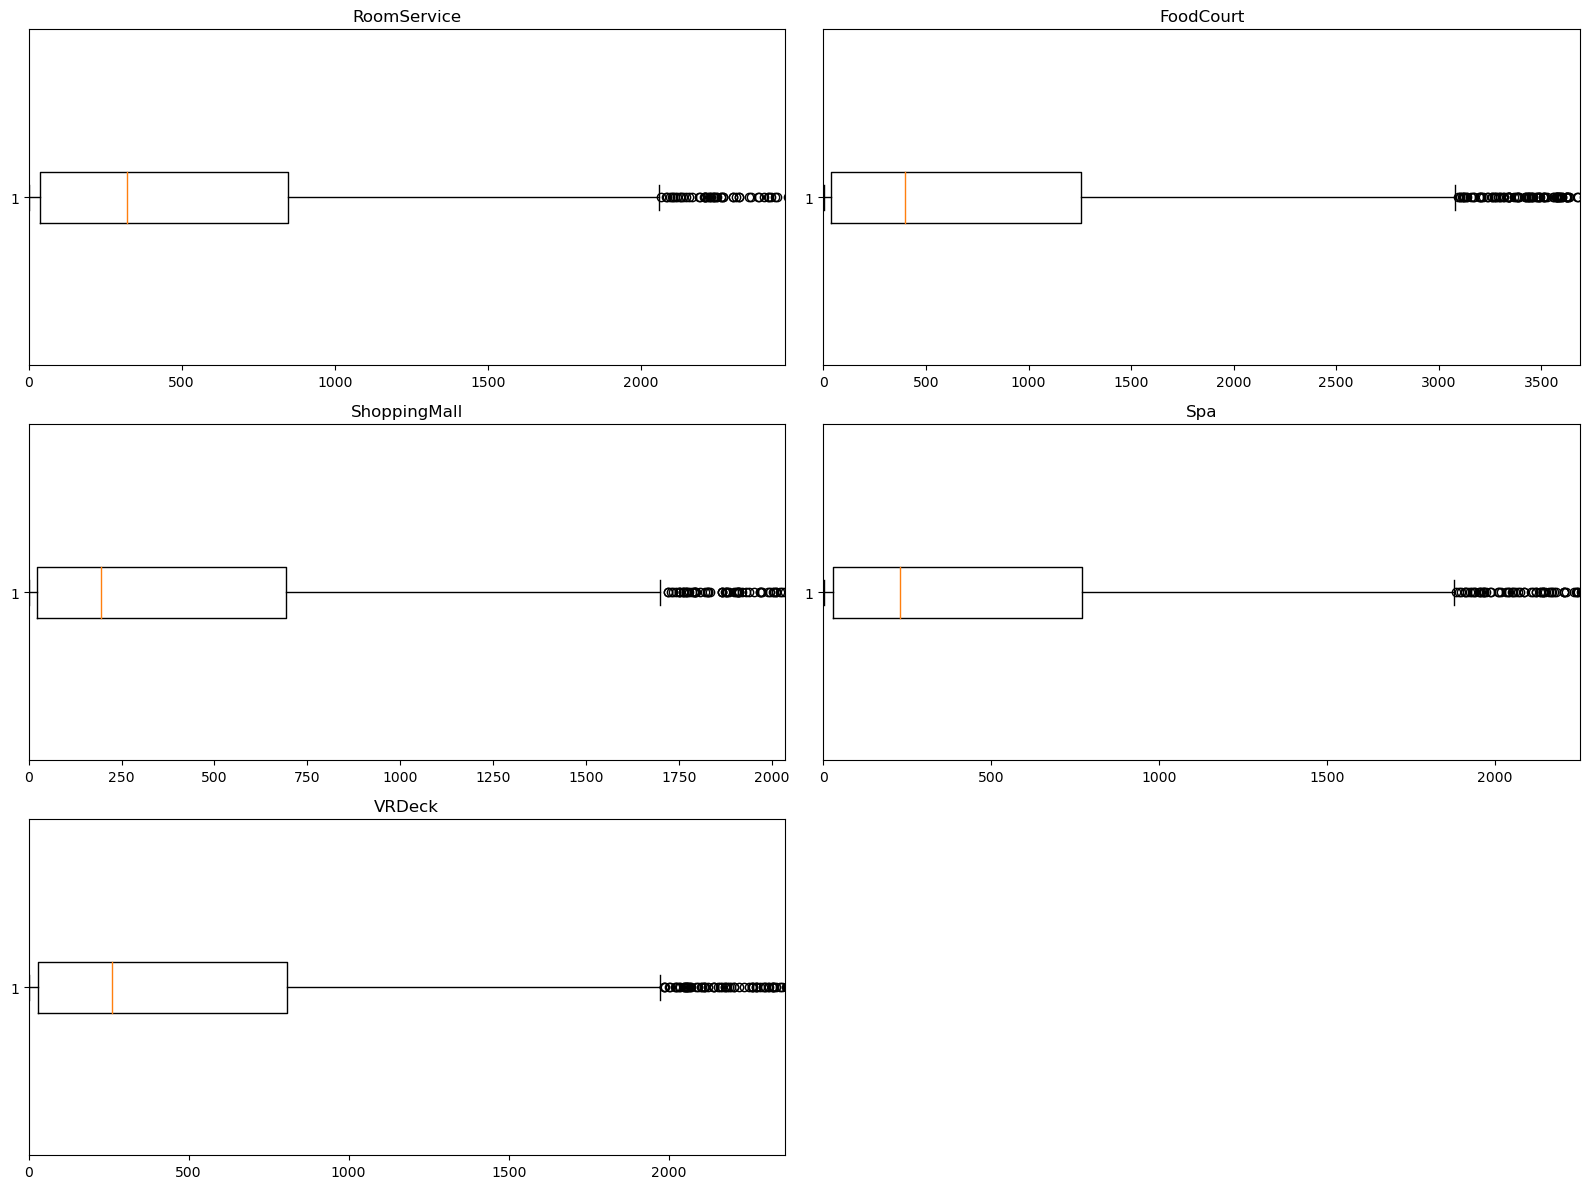

In [65]:
fig, axs = plt.subplots(3, 2, figsize=(16, 12), tight_layout=True)

i, j = 0, 0
for index, column in enumerate(columns):
    i, j = index // 2, index % 2
    rows = df_train[df_train[column] > 0][column]
    axs[i, j].boxplot(rows.dropna(), vert=False)
    axs[i, j].set_title(column)
    iqr = np.percentile(rows, 75) - np.percentile(rows, 25)
    axs[i, j].set_xlim(0, np.percentile(rows, 75) + 2 * iqr)
    
axs[i, j+1].set_visible(False)

In [66]:
df_train.fillna({col: 0.0 for col in columns}, inplace=True)
df_train[columns].isna().sum().to_frame().rename(columns={0: 'nans'})

,nans
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0
VRDeck,0


Платил - не платил, как выживаемость?

In [67]:
all_inclusive_df = df_train.loc[(df_train[columns] > 0).all(axis=1)]
print(all_inclusive_df.shape[0], 'пассажира оплатило все возможные услуги.')

252 пассажира оплатило все возможные услуги.


In [68]:
all_inclusive_df[all_inclusive_df['VIP'] == True].shape[0]

11

In [69]:
has_money_df = df_train.loc[(df_train[columns] > 0).any(axis=1)]
print(has_money_df.shape[0], 'пассажиров оплатило хотя бы одну из предоставляемых на борту услуг.')

5040 пассажиров оплатило хотя бы одну из предоставляемых на борту услуг.


In [70]:
no_money_df = df_train.loc[(df_train[columns] == 0).all(axis=1)]
print(no_money_df.shape[0], 'пассажиров не оплатило ни одной из предоставляемых на борту услуг.')
print('Из них', no_money_df[no_money_df['CryoSleep'] == True].shape[0], 'пассажира находились в состоянии криосна.')

3653 пассажиров не оплатило ни одной из предоставляемых на борту услуг.
Из них 3108 пассажира находились в состоянии криосна.


In [71]:
print('Доля успешно закончивших путешествие пассажиров из числа оплативших каждую из доступных услуг:')
all_inclusive_df[all_inclusive_df['Transported'] == True].shape[0] / all_inclusive_df.shape[0]

Доля успешно закончивших путешествие пассажиров из числа оплативших каждую из доступных услуг:


0.31746031746031744

In [72]:
print('Доля успешно закончивших путешествие пассажиров из числа оплативших хотя бы одну из доступных услуг:')
has_money_df[has_money_df['Transported'] == True].shape[0] / has_money_df.shape[0]

Доля успешно закончивших путешествие пассажиров из числа оплативших хотя бы одну из доступных услуг:


0.2986111111111111

In [73]:
print('Доля успешно закончивших путешествие пассажиров из числа не оплативших ни одну из доступных услуг:')
no_money_df[no_money_df['Transported'] == True].shape[0] / no_money_df.shape[0]

Доля успешно закончивших путешествие пассажиров из числа не оплативших ни одну из доступных услуг:


0.7864768683274022

In [74]:
df_train['has_services'] = ~(df_train[columns] == 0).all(axis=1)
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,has_services
0,0001_01,Europa,False,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,False
1,0002_01,Earth,False,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True
2,0003_01,Europa,False,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True
3,0003_02,Europa,False,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True
4,0004_01,Earth,False,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True


Пропуски в любой из рассматриваемых пяти категорий заполнены нулями по тому принципу, что раз уж никакой информации нет, то логичнее предположить, что заполнять было нечего, и вместо нуля оставили пустое значение.

Пассажиры были разделены по степени заинтересованности в услугах, а скорее по степени трат на эти услуги. Выделено три категории: пассажиры, оплатившие хотя бы одну услугу, все услуги или ни одной. Пассажиров из последней категории оказалось больше всего - порядка 57% (5040/8693). Пассажиров из первой категории тоже оказалось достаточно много - 42% от всей выборки (3653/8693). Клиентов, оплативших каждую из услуг - всего 252 человека или около 6% от размеров предыдущей категории.

После такого разделения была изучен процент успешно завершенных путешествий внутри каждой из категорий. Было замечено, что, как ни странно, пассажиры, имеющие оплаченные услуги, реже заканчивают путешествие - доля успехов составляет около 30%. В то же время пассажиры без оплаченных услуг в почти 80% случаев завершают перелет без проблем. Однако, было также замечено, что более 80% пассажиров без услуг во время перелета находились в состоянии криосна, а как было замечено в соответствующем пункте анализа, имеется некоторя корреляция между этим показателем и успешностью перелета. Поэтому можно предположить, что признак наличия оплаченных услуг является косвенным признаком успешности путешествия. 

А раз важно само наличие оплаченных услуг, решено упростить 5 категорий в одну - имелись ли хоть какие-то оплаченные услуги у пассажира. Именно в такой формулировке принято обобщить рассматриваемые категории.

---

## Name

In [75]:
df_train.Name.isna().sum()

200

In [76]:
mask = df_train['Name'].isna()
l = df_train[mask].shape[0]
df_train.loc[mask, 'Name'] = ['noname_' + str(i) for i in range(0, l)]
df_train.Name.isna().sum()

0

In [77]:
df_train['Name'].duplicated(keep=False).sum()

40

In [78]:
df_train[df_train['Name'].duplicated(keep=False)].sort_values(by='Name')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,has_services
7270,7775_01,Europa,False,P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False,True
6296,6665_01,Europa,True,P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True,False
476,0512_02,Europa,True,S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Ankalik Nateansive,True,False
2930,3176_01,Europa,False,P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True,True
8488,9071_01,Earth,False,P,55 Cancri e,22.0,False,0.0,0.0,1072.0,46.0,3.0,Anton Woody,False,True
2991,3236_03,Earth,False,P,TRAPPIST-1e,18.0,False,0.0,30.0,0.0,756.0,5.0,Anton Woody,False,True
2559,2746_01,Mars,False,P,TRAPPIST-1e,52.0,False,758.0,0.0,356.0,5.0,0.0,Apix Wala,False,True
4108,4387_01,Mars,False,P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,18.0,0.0,Apix Wala,False,True
7871,8398_01,Europa,True,S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Asch Stradick,True,False
6086,6432_01,Europa,False,P,55 Cancri e,55.0,False,114.0,222.0,0.0,2575.0,2919.0,Asch Stradick,False,True


In [79]:
df_train.drop_duplicates(subset=['Name'], keep='last', inplace=True)
df_train['Name'].duplicated().sum()

0

Имя - почти как уникальный идентификатор, логично предположить, что особой ценности для предсказания целевого параметра оно не имеет. Поэтому в дальнейшем от данного параметра мы избавимся, а сейчас удалим все строчки, в которых повторяется имя одного и того же пассажира, оставив последнюю запись. Последнюю в предположении, что у записей имеется какой-нибудь хронологический порядок, тогда последняя запись о пассажире - самая актуальная. Строк с дубликатами имен оказалось незначительно мало, поэтому даже если идея неверна, она вряд ли повлияет на конечное качество данных.

Пропуски имен были заполнены значениями по умолчанию.

---

# Оставшиеся пропуски

In [83]:
df_train.isna().sum()
df_test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

---

## Correlation matrix

In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8673 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8673 non-null   object 
 1   HomePlanet    8673 non-null   object 
 2   CryoSleep     8673 non-null   bool   
 3   Cabin         8673 non-null   object 
 4   Destination   8673 non-null   object 
 5   Age           8673 non-null   float64
 6   VIP           8673 non-null   bool   
 7   RoomService   8673 non-null   float64
 8   FoodCourt     8673 non-null   float64
 9   ShoppingMall  8673 non-null   float64
 10  Spa           8673 non-null   float64
 11  VRDeck        8673 non-null   float64
 12  Name          8673 non-null   object 
 13  Transported   8673 non-null   bool   
 14  has_services  8673 non-null   bool   
dtypes: bool(4), float64(6), object(5)
memory usage: 847.0+ KB


In [81]:
interval_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

correlation_matrix_train = df_train.phik_matrix(interval_cols=interval_cols)

In [ ]:
plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={"shrink": 0.75})

plt.title('Phi-K корреляционная матрица')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()